In [2]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, csc_matrix, lil_matrix, dok_matrix, coo_matrix, issparse, isspmatrix
from scipy.sparse.linalg import norm as sparse_norm
from scipy.sparse.linalg import eigsh, eigs, svds
from scipy.special import factorial, comb
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from itertools import combinations
from functools import reduce
from operator import mul
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [3]:
# spinful jw - single site operators

# Four basis states for each site: |0>, |↑>, |↓>, |↑↓>
ket_empty = csr_matrix([[1], [0], [0], [0]], dtype=np.complex128)  # |0>
ket_up = csr_matrix([[0], [1], [0], [0]], dtype=np.complex128)     # |↑>
ket_down = csr_matrix([[0], [0], [1], [0]], dtype=np.complex128)   # |↓>
ket_both = csr_matrix([[0], [0], [0], [1]], dtype=np.complex128)   # |↑↓>

# Single-site operators for spin-up
# Annihilation operator c_↑
c_up = csr_matrix([
    [0, 1, 0, 0],  # |0> -> 0
    [0, 0, 0, 0],  # |↑> -> |0>
    [0, 0, 0, 1],  # |↓> -> 0
    [0, 0, 0, 0]   # |↑↓> -> |↓>
], dtype=np.complex128)

# Creation operator c†_↑
c_up_dag = c_up.getH()

# Single-site operators for spin-down
# Annihilation operator c_↓
c_down = csr_matrix([
    [0, 0, 1, 0],   # |0> -> 0
    [0, 0, 0, -1],   # |↑> -> 0
    [0, 0, 0, 0],   # |↓> -> |0>
    [0, 0, 0, 0]   # |↑↓> -> -|↑> (anticommutation with c†_↑)
], dtype=np.complex128)

# Creation operator c†_↓
c_down_dag = c_down.getH()

# Number operators
n_up = c_up_dag @ c_up
n_down = c_down_dag @ c_down
n_total_site = n_up + n_down

# Identity operator (4x4 for spinful sites)
I_4 = identity(4, format='csr', dtype=np.complex128)

# Parity operator P = (-1)^n for Jordan-Wigner string
P = csr_matrix([
    [1, 0, 0, 0],   # |0> -> +|0>
    [0, -1, 0, 0],  # |↑> -> -|↑>
    [0, 0, -1, 0],  # |↓> -> -|↓>
    [0, 0, 0, 1]    # |↑↓> -> +|↑↓>
], dtype=np.complex128)

# --- Verification function ---
def verify_spinful_operators():
    """Verify the action of operators on the 4 basis states"""
    print("=== Verification of Spinful Operators ===")
    
    states = [ket_empty, ket_up, ket_down, ket_both]
    state_names = ["|0>", "|↑>", "|↓>", "|↑↓>"]
    
    print("\n1. Spin-up creation operator c†_↑:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_up_dag @ state
        print(f"   c†_↑ {name} = {result.toarray().flatten()}")
    
    print("\n2. Spin-up annihilation operator c_↑:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_up @ state
        print(f"   c_↑ {name} = {result.toarray().flatten()}")
    
    print("\n3. Spin-down creation operator c†_↓:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_down_dag @ state
        print(f"   c†_↓ {name} = {result.toarray().flatten()}")
    
    print("\n4. Spin-down annihilation operator c_↓:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_down @ state
        print(f"   c_↓ {name} = {result.toarray().flatten()}")
    
    print("\n5. Number operators:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        n_up_result = (n_up @ state).toarray().flatten()
        n_down_result = (n_down @ state).toarray().flatten()
        n_total_result = (n_total_site @ state).toarray().flatten()
        print(f"   n_↑ {name} = {n_up_result}")
        print(f"   n_↓ {name} = {n_down_result}")
        print(f"   n_total {name} = {n_total_result}")
    
    print("\n6. Parity operator P:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = (P @ state).toarray().flatten()
        print(f"   P {name} = {result}")
    
    print("\n7. Verify anticommutation on same site:")
    # {c_↑, c†_↓} = 0 and {c_↓, c†_↑} = 0
    anticomm1 = c_up @ c_down_dag + c_down_dag @ c_up
    anticomm2 = c_down @ c_up_dag + c_up_dag @ c_down
    print(f"   {{c_↑, c†_↓}} = \n{anticomm1.toarray()}")
    print(f"   {{c_↓, c†_↑}} = \n{anticomm2.toarray()}")
    
    # {c_↑, c†_↑} = 1 and {c_↓, c†_↓} = 1
    anticomm3 = c_up @ c_up_dag + c_up_dag @ c_up
    anticomm4 = c_down @ c_down_dag + c_down_dag @ c_down
    print(f"   {{c_↑, c†_↑}} = \n{anticomm3.toarray()}")
    print(f"   {{c_↓, c†_↓}} = \n{anticomm4.toarray()}")


# Run verification
verify_spinful_operators()

=== Verification of Spinful Operators ===

1. Spin-up creation operator c†_↑:
   c†_↑ |0> = [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
   c†_↑ |↑> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c†_↑ |↓> = [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
   c†_↑ |↑↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]

2. Spin-up annihilation operator c_↑:
   c_↑ |0> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↑ |↑> = [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↑ |↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↑ |↑↓> = [0.+0.j 0.+0.j 1.+0.j 0.+0.j]

3. Spin-down creation operator c†_↓:
   c†_↓ |0> = [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
   c†_↓ |↑> = [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
   c†_↓ |↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c†_↓ |↑↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]

4. Spin-down annihilation operator c_↓:
   c_↓ |0> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↓ |↑> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↓ |↓> = [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↓ |↑↓> = [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]

5. Number operators:
   n_↑ |0> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   n_↓ |0> = [0.+0.j 0.+0.j 0.+

In [4]:
def full_operator_spinful(L, op, site):
    """
    Create full fermionic operator with Jordan-Wigner string
    Args:
        L: number of sites
        op: single-site operator (c_up, c_up_dag, c_down, c_down_dag, etc.)
        site: site index (0 to L-1)
    """
    if site >= L or site < 0:
        raise ValueError(f"Site index {site} out of range for {L} sites")
    
    result = 1
    for i in range(L):
        if i < site:
            # Jordan-Wigner string: parity operator for all sites to the left
            result = kron(result, P, format='csr')
        elif i == site:
            # Apply the operator at the target site
            result = kron(result, op, format='csr')
        else:
            # Identity for sites to the right
            result = kron(result, I_4, format='csr')
    return result

def creation_operator_up(L, site):
    """Creation operator c†_↑,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_up_dag, site)

def annihilation_operator_up(L, site):
    """Annihilation operator c_↑,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_up, site)

def creation_operator_down(L, site):
    """Creation operator c†_↓,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_down_dag, site)

def annihilation_operator_down(L, site):
    """Annihilation operator c_↓,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_down, site)

def number_operator_up(L, site):
    """Number operator n_↑,i = c†_↑,i c_↑,i"""
    return full_operator_spinful(L, n_up, site)

def number_operator_down(L, site):
    """Number operator n_↓,i = c†_↓,i c_↓,i"""
    return full_operator_spinful(L, n_down, site)

def number_operator_total_site(L, site):
    """Total number operator n_i = n_↑,i + n_↓,i"""
    return full_operator_spinful(L, n_total_site, site)

def total_number_operator_spinful(L):
    """Total number operator N = Σ_i (n_↑,i + n_↓,i)"""
    N_total = csr_matrix((4**L, 4**L), dtype=np.complex128)
    for i in range(L):
        N_total += number_operator_up(L, i)
        N_total += number_operator_down(L, i)
    return N_total

# --- Check anticommutation relations ---
def check_anticommutation_spinful(L, site_i, site_j):
    """Check anticommutators for spinful fermion operators"""
    # Get all operators
    ci_up = annihilation_operator_up(L, site_i)
    ci_up_dag = creation_operator_up(L, site_i)
    ci_down = annihilation_operator_down(L, site_i)
    ci_down_dag = creation_operator_down(L, site_i)
    
    cj_up = annihilation_operator_up(L, site_j)
    cj_up_dag = creation_operator_up(L, site_j)
    cj_down = annihilation_operator_down(L, site_j)
    cj_down_dag = creation_operator_down(L, site_j)
    
    results = {}
    
    # Same site, same spin: {c_σ,i, c†_σ,i} = 1
    anticomm_same_up = ci_up @ ci_up_dag + ci_up_dag @ ci_up
    anticomm_same_down = ci_down @ ci_down_dag + ci_down_dag @ ci_down
    results[f"{{c_↑,{site_i}, c†_↑,{site_i}}}"] = anticomm_same_up.todense()
    results[f"{{c_↓,{site_i}, c†_↓,{site_i}}}"] = anticomm_same_down.todense()
    
    if site_i != site_j:
        # Different sites, same spin: {c_σ,i, c†_σ,j} = 0
        anticomm_diff_up = ci_up @ cj_up_dag + cj_up_dag @ ci_up
        anticomm_diff_down = ci_down @ cj_down_dag + cj_down_dag @ ci_down
        results[f"{{c_↑,{site_i}, c†_↑,{site_j}}}"] = anticomm_diff_up.todense()
        results[f"{{c_↓,{site_i}, c†_↓,{site_j}}}"] = anticomm_diff_down.todense()
        
        # Different sites, different spins: {c_σ,i, c†_σ',j} = 0
        anticomm_diff_mixed1 = ci_up @ cj_down_dag + cj_down_dag @ ci_up
        anticomm_diff_mixed2 = ci_down @ cj_up_dag + cj_up_dag @ ci_down
        results[f"{{c_↑,{site_i}, c†_↓,{site_j}}}"] = anticomm_diff_mixed1.todense()
        results[f"{{c_↓,{site_i}, c†_↑,{site_j}}}"] = anticomm_diff_mixed2.todense()
    
    # Same site, different spins: {c_σ,i, c†_σ',i} = 0
    anticomm_same_mixed1 = ci_up @ ci_down_dag + ci_down_dag @ ci_up
    anticomm_same_mixed2 = ci_down @ ci_up_dag + ci_up_dag @ ci_down
    results[f"{{c_↑,{site_i}, c†_↓,{site_i}}}"] = anticomm_same_mixed1.todense()
    results[f"{{c_↓,{site_i}, c†_↑,{site_i}}}"] = anticomm_same_mixed2.todense()
    
    return results

# check anticommutation relations for L sites
L = 4
anticom_results = check_anticommutation_spinful(L, 0, 1)
for key, value in anticom_results.items():
    print(f"{key}: {np.round(value, 5)}")

{c_↑,0, c†_↑,0}: [[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
{c_↓,0, c†_↓,0}: [[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
{c_↑,0, c†_↑,1}: [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
{c_↓,0, c†_↓,1}: [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.

In [5]:
# Fixed Normal ordering for spinful fermion operators with proper swap counting

def get_operator_priority(op_type, site, spin):
    """
    Get priority for operator ordering:
    1. Creation operators first (lower priority number)
    2. Within creation/annihilation: increasing site number
    3. Within same site: up spin before down spin
    """
    if op_type == 'c_dag':
        base_priority = 0  # Creation operators come first
    else:  # op_type == 'c'
        base_priority = 1000  # Annihilation operators come after
    
    site_priority = site * 10  # Site ordering
    
    if spin == 'up':
        spin_priority = 0
    else:  # spin == 'down'
        spin_priority = 1
    
    return base_priority + site_priority + spin_priority

def count_swaps_to_sort(operators_list):
    """
    Count the number of adjacent swaps needed to sort operators by priority.
    This is equivalent to counting inversions, which gives the correct sign.
    """
    if len(operators_list) <= 1:
        return 0, operators_list
    
    # Create list with priorities and original positions
    indexed_ops = [(get_operator_priority(op[0], op[1], op[2]), i, op) 
                   for i, op in enumerate(operators_list)]
    
    # Use bubble sort to count swaps (this counts exactly the inversions)
    ops_copy = indexed_ops.copy()
    swap_count = 0
    n = len(ops_copy)
    
    for i in range(n):
        for j in range(0, n - i - 1):
            if ops_copy[j][0] > ops_copy[j + 1][0]:
                # Swap needed - this represents an anticommutation
                ops_copy[j], ops_copy[j + 1] = ops_copy[j + 1], ops_copy[j]
                swap_count += 1
    
    # Extract the sorted operator list
    sorted_ops = [op[2] for op in ops_copy]
    
    return swap_count, sorted_ops

def normal_order_operator_list(operators_list):
    """
    Normal order a list of (op_type, site, spin) tuples.
    Returns: (sign, ordered_list) where sign accounts for fermion anticommutations
    """
    if len(operators_list) <= 1:
        return 1.0, operators_list
    
    # Count swaps needed and get sorted list
    swap_count, sorted_ops = count_swaps_to_sort(operators_list)
    
    # Each swap introduces a minus sign due to anticommutation
    sign = (-1) ** swap_count
    
    return sign, sorted_ops

def normal_order_product_spinful(operators_list, L):
    """
    Normal order a product of spinful fermion operators and return the resulting operator.
    
    Args:
        operators_list: List of (op_type, site, spin) tuples
                       op_type: 'c_dag' or 'c'
                       site: integer site index
                       spin: 'up' or 'down'
        L: system size
        
    Returns:
        List of (coefficient, sparse_matrix) tuples representing normal ordered terms
    """
    if len(operators_list) == 0:
        identity_op = identity(4**L, format='csr', dtype=np.complex128)
        return [(1.0, identity_op)]
    
    # Check for repeated operators that give zero (Pauli exclusion)
    op_counts = {}
    for op in operators_list:
        key = (op[0], op[1], op[2])  # (type, site, spin)
        op_counts[key] = op_counts.get(key, 0) + 1 # for a given key, the corresponding value is the count
    
    # If any operator appears more than once, result is zero
    for count in op_counts.values():
        if count > 1:
            zero_op = csr_matrix((4**L, 4**L), dtype=np.complex128)
            return [(0.0, zero_op)]
    
    # Get the normal ordered form with correct sign
    sign, ordered_ops = normal_order_operator_list(operators_list)
    
    # Construct the full operator by multiplying individual operators
    result_op = identity(4**L, format='csr', dtype=np.complex128)
    
    for op_type, site, spin in ordered_ops:
        if op_type == 'c_dag' and spin == 'up':
            op = creation_operator_up(L, site)
        elif op_type == 'c_dag' and spin == 'down':
            op = creation_operator_down(L, site)
        elif op_type == 'c' and spin == 'up':
            op = annihilation_operator_up(L, site)
        elif op_type == 'c' and spin == 'down':
            op = annihilation_operator_down(L, site)
        else:
            raise ValueError(f"Invalid operator: {op_type}, {spin}")
        
        result_op = result_op @ op
    
    return [(complex(sign), result_op)]

def print_operator_sequence(operators_list):
    """Print the operator sequence in readable form"""
    op_strings = []
    for op_type, site, spin in operators_list:
        if op_type == 'c_dag':
            symbol = f"c†_{spin[0]},{site}"
        else:
            symbol = f"c_{spin[0]},{site}"
        op_strings.append(symbol)
    return " ".join(op_strings)

def test_normal_ordering_comprehensive():
    """Comprehensive test of the normal ordering function"""
    L = 4
    print("=== Comprehensive Normal Ordering Tests ===\n")
    
    # Test 1: Already in normal order
    print("Test 1: c†_u,0 c†_d,0 (already normal ordered)")
    ops = [('c_dag', 0, 'up'), ('c_dag', 0, 'down')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 0 (already ordered)\n")
    
    # Test 2: Simple swap - spin ordering
    print("Test 2: c†_d,0 c†_u,0 -> need to swap spins")
    ops = [('c_dag', 0, 'down'), ('c_dag', 0, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 1 -> sign = (-1)^1 = -1\n")
    
    # Test 3: Site ordering
    print("Test 3: c†_u,1 c†_u,0 -> need to swap sites")
    ops = [('c_dag', 1, 'up'), ('c_dag', 0, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 1 -> sign = (-1)^1 = -1\n")
    
    # Test 4: Creation vs annihilation
    print("Test 4: c_u,0 c†_u,1 -> creation should come first")
    ops = [('c', 0, 'up'), ('c_dag', 1, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 1 -> sign = (-1)^1 = -1\n")
    
    # Test 5: Multiple swaps
    print("Test 5: c_d,1 c†_d,0 c_u,0 c†_u,1 -> multiple reorderings")
    ops = [('c', 1, 'down'), ('c_dag', 0, 'down'), ('c', 0, 'up'), ('c_dag', 1, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    
    # Let's manually trace the swaps:
    # Start: c_d,1 c†_d,0 c_u,0 c†_u,1
    # Target order: c†_u,0 c†_d,0 c†_u,1 c_u,0 c_d,1
    # But we need c†_u,1 not c†_u,0 twice, so:
    # Target: c†_u,1 c†_d,0 c_u,0 c_d,1
    
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    
    # Count swaps manually to verify
    swap_count, _ = count_swaps_to_sort(ops)
    print(f"Swaps needed: {swap_count} -> sign = (-1)^{swap_count} = {(-1)**swap_count}\n")
    
    # Test 6: Complex example with many operators
    print("Test 6: Complex example - c_d,2 c†_u,0 c_u,1 c†_d,1 c†_u,2")
    ops = [('c', 2, 'down'), ('c_dag', 0, 'up'), ('c', 1, 'up'), ('c_dag', 1, 'down'), ('c_dag', 2, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    swap_count, _ = count_swaps_to_sort(ops)
    print(f"Swaps needed: {swap_count} -> sign = (-1)^{swap_count} = {(-1)**swap_count}\n")
    
    # Test 7: Repeated operator (should give zero)
    print("Test 7: c†_u,0 c†_u,0 -> should be zero (Pauli exclusion)")
    ops = [('c_dag', 0, 'up'), ('c_dag', 0, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    result = normal_order_product_spinful(ops, L)
    print(f"Result coefficient: {result[0][0]} (should be 0)\n")

def verify_anticommutation_with_normal_ordering():
    """Verify that our normal ordering respects anticommutation relations"""
    L = 3
    print("=== Verification: Normal Ordering vs Direct Anticommutation ===\n")
    
    # Test: c†_u,0 c†_d,1 vs c†_d,1 c†_u,0
    print("Comparing c†_u,0 c†_d,1 vs c†_d,1 c†_u,0:")
    
    # First order
    ops1 = [('c_dag', 0, 'up'), ('c_dag', 1, 'down')]
    result1 = normal_order_product_spinful(ops1, L)
    op1 = result1[0][1]
    coeff1 = result1[0][0]
    
    # Second order (swapped)
    ops2 = [('c_dag', 1, 'down'), ('c_dag', 0, 'up')]
    result2 = normal_order_product_spinful(ops2, L)
    op2 = result2[0][1]
    coeff2 = result2[0][0]

    print(op1.toarray())
    print(op2.toarray())
    
    print(f"First:  {print_operator_sequence(ops1)} -> coeff = {np.real(coeff1)}")
    print(f"Second: {print_operator_sequence(ops2)} -> coeff = {np.real(coeff2)}")
    
    # Check if op1 = -op2 (they should be negatives of each other)
    diff = op1 + coeff2 * op2
    is_anticommuting = np.allclose(diff.toarray(), 0)
    print(f"Are they anticommuting? {is_anticommuting}")
    print(f"Coefficient ratio: {np.real(coeff2/coeff1)} (should be -1)\n")

# Run comprehensive tests
test_normal_ordering_comprehensive()
verify_anticommutation_with_normal_ordering()

=== Comprehensive Normal Ordering Tests ===

Test 1: c†_u,0 c†_d,0 (already normal ordered)
Original: c†_u,0 c†_d,0
Normal ordered: +1 × c†_u,0 c†_d,0
Swaps needed: 0 (already ordered)

Test 2: c†_d,0 c†_u,0 -> need to swap spins
Original: c†_d,0 c†_u,0
Normal ordered: -1 × c†_u,0 c†_d,0
Swaps needed: 1 -> sign = (-1)^1 = -1

Test 3: c†_u,1 c†_u,0 -> need to swap sites
Original: c†_u,1 c†_u,0
Normal ordered: -1 × c†_u,0 c†_u,1
Swaps needed: 1 -> sign = (-1)^1 = -1

Test 4: c_u,0 c†_u,1 -> creation should come first
Original: c_u,0 c†_u,1
Normal ordered: -1 × c†_u,1 c_u,0
Swaps needed: 1 -> sign = (-1)^1 = -1

Test 5: c_d,1 c†_d,0 c_u,0 c†_u,1 -> multiple reorderings
Original: c_d,1 c†_d,0 c_u,0 c†_u,1
Normal ordered: +1 × c†_d,0 c†_u,1 c_u,0 c_d,1
Swaps needed: 4 -> sign = (-1)^4 = 1

Test 6: Complex example - c_d,2 c†_u,0 c_u,1 c†_d,1 c†_u,2
Original: c_d,2 c†_u,0 c_u,1 c†_d,1 c†_u,2
Normal ordered: +1 × c†_u,0 c†_d,1 c†_u,2 c_u,1 c_d,2
Swaps needed: 6 -> sign = (-1)^6 = 1

Test 7: c†

In [6]:
# OSS.: FERMIONS COME IN PAIRS IN THE ETA SCARS SO THAT THEY CAN BE EFFECTIVELY TREATED LIKE BOSONS WHEN COMPUTING THE PARTIAL TRACE

'''
def ptrace_sparse_normal_ordered(dm_sparse, keep, trace, L):
    """
    Compute partial trace using normal-ordered fermion operators.
    
    Args:
        dm_sparse: Full density matrix in sparse format
        keep: List of site indices to keep  
        trace: List of site indices to trace out
        L: Total number of sites
        
    Returns:
        Reduced density matrix over kept sites
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    
    dims = [4] * L  # 4 states per site for spinful fermions
    d_keep = 4 ** len(keep)
    
    # Convert to COO format for element-wise processing
    dm_sparse = dm_sparse.tocoo()
    
    # Storage for reduced matrix
    data = []
    row_idx = []
    col_idx = []
    
    def basis_state_to_operators(state_idx, sites):
        """Convert a basis state index to creation operators from vacuum"""
        state_config = idx_to_subsys(state_idx, [4] * len(sites))
        operators = []
        
        for i, site in enumerate(sites):
            local_state = state_config[i]
            # Convert local state to operators: |0⟩, |↑⟩, |↓⟩, |↑↓⟩
            if local_state == 1:  # |↑⟩
                operators.append(('c_dag', site, 'up'))
            elif local_state == 2:  # |↓⟩  
                operators.append(('c_dag', site, 'down'))
            elif local_state == 3:  # |↑↓⟩
                operators.append(('c_dag', site, 'up'))
                operators.append(('c_dag', site, 'down'))
            # local_state == 0 corresponds to vacuum, no operators needed
                
        return operators
    
    def compute_traced_expectation(bra_ops, ket_ops, trace_sites):
        """
        Compute ⟨trace_bra|operator_sequence|trace_ket⟩ using normal ordering.
        This gives the coefficient when we trace out the specified sites.
        """
        # For partial trace: ⟨trace_state|ket_ops† bra_ops|trace_state⟩  
        # We need to compute: ⟨0|bra_ops† ket_ops|0⟩ for each trace state
        
        total_expectation = 0.0
        
        # Sum over all possible states of traced subsystem
        for trace_state_idx in range(4 ** len(trace_sites)):
            trace_config = idx_to_subsys(trace_state_idx, [4] * len(trace_sites))
            
            # Create the trace state operators
            trace_bra_ops = basis_state_to_operators(trace_state_idx, trace_sites)
            trace_ket_ops = trace_bra_ops.copy()  # Same state for bra and ket
            
            # Build full operator sequence: 
            # ⟨trace_bra| ket_ops† bra_ops |trace_ket⟩
            # = ⟨0| trace_bra_ops† ket_ops† bra_ops trace_ket_ops |0⟩
            
            full_operator_sequence = []
            
            # Add annihilation operators for trace bra (reversed order for hermitian conjugate)
            for op_type, site, spin in reversed(trace_bra_ops):
                if op_type == 'c_dag':
                    full_operator_sequence.append(('c', site, spin))
            
            # Add hermitian conjugate of ket operators (creation → annihilation, reverse order)
            for op_type, site, spin in reversed(ket_ops):
                if op_type == 'c_dag':
                    full_operator_sequence.append(('c', site, spin))
                else:  # op_type == 'c'
                    full_operator_sequence.append(('c_dag', site, spin))
            
            # Add bra operators
            full_operator_sequence.extend(bra_ops)
            
            # Add creation operators for trace ket
            full_operator_sequence.extend(trace_ket_ops)
            
            # Normal order and compute vacuum expectation value
            try:
                result = normal_order_product_spinful(full_operator_sequence, L)
                if len(result) > 0:
                    coeff, matrix = result[0]
                    
                    # For vacuum expectation value, we need ⟨0|O|0⟩
                    # This is non-zero only if the normal-ordered operator is identity
                    vacuum_state = vacuum_state_spinful(L)
                    expectation_val = (vacuum_state.getH() @ matrix @ vacuum_state)[0,0]
                    
                    total_expectation += expectation_val
                    
            except Exception as e:
                # Handle cases where normal ordering fails (e.g., invalid operators)
                continue
                
        return total_expectation
    
    # Process each non-zero element of the density matrix
    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        # Convert full space indices to site configurations
        full_bra_config = idx_to_subsys(i, dims)  # ⟨i|
        full_ket_config = idx_to_subsys(j, dims)  # |j⟩
        
        # Extract configurations for kept and traced sites
        keep_bra_config = [full_bra_config[site] for site in keep]
        keep_ket_config = [full_ket_config[site] for site in keep]
        trace_bra_config = [full_bra_config[site] for site in trace]
        trace_ket_config = [full_ket_config[site] for site in trace]
        
        # Convert to operator sequences
        keep_bra_ops = basis_state_to_operators(
            sum(keep_bra_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep))), 
            keep
        )
        keep_ket_ops = basis_state_to_operators(
            sum(keep_ket_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep))), 
            keep
        )
        trace_bra_ops = basis_state_to_operators(
            sum(trace_bra_config[k] * (4**(len(trace)-1-k)) for k in range(len(trace))), 
            trace
        )
        trace_ket_ops = basis_state_to_operators(
            sum(trace_ket_config[k] * (4**(len(trace)-1-k)) for k in range(len(trace))), 
            trace
        )
        
        # Compute traced expectation value using normal ordering
        if trace_bra_config == trace_ket_config:  # Only diagonal elements in trace space contribute
            traced_coeff = compute_traced_expectation(trace_bra_ops, trace_ket_ops, trace)
            
            if abs(traced_coeff) > 1e-14:  # Only include non-zero contributions
                # Compute reduced space indices
                i_red = sum(keep_bra_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep)))
                j_red = sum(keep_ket_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep)))
                
                # Add to reduced matrix
                data.append(val * traced_coeff)
                row_idx.append(i_red)
                col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def idx_to_subsys(idx, dims):
    """Convert flat index to subsystem indices (reuse from your existing code)"""
    subsys = []
    for d in reversed(dims):
        subsys.append(idx % d)
        idx //= d
    return np.array(subsys[::-1])

    '''

'\ndef ptrace_sparse_normal_ordered(dm_sparse, keep, trace, L):\n    """\n    Compute partial trace using normal-ordered fermion operators.\n    \n    Args:\n        dm_sparse: Full density matrix in sparse format\n        keep: List of site indices to keep  \n        trace: List of site indices to trace out\n        L: Total number of sites\n        \n    Returns:\n        Reduced density matrix over kept sites\n    """\n    if not issparse(dm_sparse):\n        raise ValueError("dm_sparse must be a scipy.sparse matrix")\n    \n    dims = [4] * L  # 4 states per site for spinful fermions\n    d_keep = 4 ** len(keep)\n    \n    # Convert to COO format for element-wise processing\n    dm_sparse = dm_sparse.tocoo()\n    \n    # Storage for reduced matrix\n    data = []\n    row_idx = []\n    col_idx = []\n    \n    def basis_state_to_operators(state_idx, sites):\n        """Convert a basis state index to creation operators from vacuum"""\n        state_config = idx_to_subsys(state_idx, [4

In [7]:
def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size, bc):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    
    Args:
        L: system size  
        block_size: size of the block
        bc: boundary conditions ('obc' or 'pbc')
    """
    blocks = []
    
    if bc == 'obc':
        # Original OBC implementation
        for start in range(L - block_size + 1):
            blocks.append(list(range(start, start + block_size)))
    
    elif bc == 'pbc':
        # PBC implementation - sites wrap around
        for start in range(L):
            block = []
            for i in range(block_size):
                block.append((start + i) % L)  # Wrap around using modulo
            blocks.append(block)
    
    else:
        raise ValueError("Boundary condition must be 'obc' or 'pbc'")
    
    return blocks

def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    

    dm_sparse = dm_sparse.tocoo()

    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])


    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    
    dm_sparse = dm_sparse.tocoo()

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data))
    )
    results = [r for r in results if r is not None]

    '''entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    results = []
    with ThreadPoolExecutor() as executor:
        for res in executor.map(process_entry, entries):
            if res is not None:
                results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

# ...existing code...

def fermionic_sign(full_config, keep, trace):
    """
    Compute the fermionic sign for a given occupation configuration
    when reordering sites to bring 'keep' sites to the front.
    full_config: array of site occupations (length L)
    keep: list of kept site indices
    trace: list of traced site indices
    """
    # Build the permutation that brings keep+trace to original order
    perm = keep + trace
    # For each pair (i<j), if perm[i] > perm[j] and both are occupied, count a swap
    sign = 1
    occ = np.array(full_config)
    # Only need to count swaps between occupied sites
    for i in range(len(perm)):
        for j in range(i+1, len(perm)):
            if perm[i] > perm[j] and occ[perm[i]] and occ[perm[j]]:
                sign *= -1
    return sign

def ptrace_sparse_fermionic(dm_sparse, keep, dims):
    """
    Partial trace for fermions, including the correct sign.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    data = []
    row_idx = []
    col_idx = []

    dm_sparse = dm_sparse.tocoo()

    def idx_to_subsys(idx, dims):
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)
        # Only keep terms where traced sites match
        if np.all(bi[trace] == bj[trace]):
            # Compute fermionic sign for this configuration
            sign_i = fermionic_sign(bi, keep, trace)
            sign_j = fermionic_sign(bj, keep, trace)
            sign = sign_i * sign_j
            # Map to reduced indices
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            data.append(val * sign)
            row_idx.append(i_red)
            col_idx.append(j_red)

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ptrace_sparse_fermionic_parallel(dm_sparse, keep, dims, n_jobs=-1):
    """
    Parallel partial trace for fermions, including the correct sign.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])

    def idx_to_subsys(idx, dims):
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    dm_sparse = dm_sparse.tocoo()

    def process_entry_fermionic(i, j, val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            # Compute fermionic sign for this configuration
            sign_i = fermionic_sign(bi, keep, trace)
            sign_j = fermionic_sign(bj, keep, trace)
            sign = sign_i * sign_j
            # Map to reduced indices
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val * sign, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry_fermionic)(i, j, val)
        for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data))
    )
    results = [r for r in results if r is not None]
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

# ...existing code...

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [4] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [4] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[4] * L, [4] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[4] * L, [4] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [8]:
def schmidt_sparse(psi, dims, sysA, rtol=1e-12, normalize=True):
    """
    Schmidt decomposition for a sparse pure state.

    Parameters
    ----------
    psi : scipy.sparse.csr_matrix or csc_matrix
        Column vector (D, 1) in computational basis.
    dims : list[int]
        Local dimensions, e.g., [2,2,2].
    sysA : list[int]
        Indices of subsystem A.
    rtol : float
        Relative tol for zeroing small coeffs.
    normalize : bool
        Normalize psi before decomposition.

    Returns
    -------
    s : ndarray
        Schmidt coefficients.
    U : scipy.sparse matrix
        Left Schmidt basis (A) as sparse.
    V : scipy.sparse matrix
        Right Schmidt basis (B) as sparse.
    """
    assert isspmatrix(psi) and psi.shape[1] == 1, "psi must be sparse column vector"
    n = len(dims)
    D = np.prod(dims)
    assert psi.shape[0] == D, "dims mismatch"

    if normalize:
        norm = sparse_norm(psi)
        if norm == 0:
            raise ValueError("Zero vector.")
        psi = psi / norm

    sysA = list(sysA)
    sysB = [i for i in range(n) if i not in sysA]
    A_shape = tuple(dims[i] for i in sysA)
    B_shape = tuple(dims[i] for i in sysB)
    dA = reduce(mul, A_shape, 1)
    dB = reduce(mul, B_shape, 1)

    # Reshape via index mapping without making dense
    coords = psi.nonzero()[0]
    data = psi.data
    
    # Check if state is zero
    if len(coords) == 0:
        # Return zero Schmidt decomposition
        s = np.array([])
        U = csr_matrix((dA, 0), dtype=np.complex128)
        V = csr_matrix((dB, 0), dtype=np.complex128)
        return s, U, V, {"A_shape": A_shape, "B_shape": B_shape}
    
    A_idx = np.zeros_like(coords)
    B_idx = np.zeros_like(coords)
    for m, flat in enumerate(coords):
        multi = np.unravel_index(flat, dims)
        A_multi = tuple(multi[i] for i in sysA)
        B_multi = tuple(multi[i] for i in sysB)
        A_idx[m] = np.ravel_multi_index(A_multi, A_shape)
        B_idx[m] = np.ravel_multi_index(B_multi, B_shape)

    M = csr_matrix((data, (A_idx, B_idx)), shape=(dA, dB))

    # SVD for sparse matrices: use svds to get all nonzero singular values
    # For large systems, you might want only k largest singular values.
    if M.nnz == 0:
        # Handle empty matrix case
        s = np.array([])
        U = csr_matrix((dA, 0), dtype=np.complex128)
        V = csr_matrix((dB, 0), dtype=np.complex128)
        return s, U, V, {"A_shape": A_shape, "B_shape": B_shape}
    
    # Determine k for svds: must satisfy 0 < k < min(M.shape)
    min_dim = min(M.shape)
    max_k = min_dim - 1
    k = min(min(dA, dB), M.nnz)  # safe upper bound
    k = min(k, max_k)
    
    # If k is too close to the matrix dimensions, use dense SVD instead
    if k >= max_k or min_dim <= 2:
        # Use dense SVD for small matrices or when k is too large
        M_dense = M.toarray()
        U_dense, s, Vh_dense = np.linalg.svd(M_dense, full_matrices=False)
        
        # Convert back to sparse
        # Keep only non-zero singular values
        tol = rtol * s[0] if len(s) > 0 else 0
        keep = s > tol
        s = s[keep]
        U = csr_matrix(U_dense[:, keep])
        V = csr_matrix(Vh_dense[keep, :].conj().T)
    else:
        # Use sparse SVD
        if k <= 0:
            k = 1
        
        U, s, Vh = svds(M, k=k)
        # svds returns ascending singular values
        order = np.argsort(s)[::-1]
        s = s[order]
        U = csr_matrix(U[:, order])
        V = csr_matrix(Vh[order, :].conj().T)

        # Drop small singular values
        if s.size:
            smax = s[0]
            keep = s > rtol * smax
            s, U, V = s[keep], U[:, keep], V[:, keep]

    return s, U, V, {"A_shape": A_shape, "B_shape": B_shape}

def entanglement_from_s(s, base=np.e):
    """Entanglement measures from Schmidt coeffs s."""
    if len(s) == 0:
        return np.array([]), 0.0, 0.0, np.array([])
    
    lam = s**2
    lam /= lam.sum()
    nz = lam > 0
    log = np.log if base == np.e else (lambda x: np.log(x)/np.log(base))
    S_vN = -np.sum(lam[nz] * log(lam[nz]))
    S2 = -log(np.sum(lam**2))
    eps = np.full_like(lam, np.inf)
    eps[nz] = -log(lam[nz])
    return lam, S_vN, S2, eps

# Fixed example
if __name__ == "__main__":
    # 2-qubit Bell state as sparse vector
    dims = [2, 2]
    bell = lil_matrix((4, 1), dtype=complex)
    bell[0, 0] = 1/np.sqrt(2)
    bell[3, 0] = 1/np.sqrt(2)
    
    print("Bell state non-zeros:", bell.nnz)
    print("Bell state data:", bell.tocsr().data)
    
    s, UA, UB, shapes = schmidt_sparse(bell.tocsr(), dims, sysA=[0])
    print("Schmidt coeffs:", s)
    if len(s) > 0:
        lam, S_vN, S2, eps = entanglement_from_s(s)
        print("Entropy:", S_vN)
        print("Schmidt probabilities:", lam)
    else:
        print("Entropy: 0 (no entanglement)")

Bell state non-zeros: 2
Bell state data: [0.70710678+0.j 0.70710678+0.j]
Schmidt coeffs: [0.70710678 0.70710678]
Entropy: 0.6931471805599453
Schmidt probabilities: [0.5 0.5]


In [9]:
# eta pairing states

# --- vacuum/initial state ---
def vacuum_state_spinful(L):
    """Create vacuum state |0>^⊗L for L sites"""
    state = ket_empty
    for _ in range(L-1):
        state = kron(state, ket_empty, format='csr')
    return state

# --- eta^+ operator ---
def eta_plus(L):
    etap = csr_matrix((4**L, 4**L), dtype=complex)
    for k in range(L):
        phase = np.exp(1j * np.pi * k)
        eplus = creation_operator_up(L, k).dot(creation_operator_down(L, k))
        etap += phase * eplus

    return etap

def t_plus(L, bc = 'periodic'):
    tp = csr_matrix((4**L, 4**L), dtype=complex)
    for k in range(L):
        phase = np.exp(1j * np.pi * k)
        tplus = creation_operator_up(L, k).dot(creation_operator_up(L, (k+1) % L))
        tp += phase * tplus

    return tp


def s_plus(L, bc = 'periodic'):
    sp = csr_matrix((4**L, 4**L), dtype=complex)
    for k in range(L):
        phase = np.exp(1j * np.pi * k)
        splus = (creation_operator_up(L, k).dot(creation_operator_down(L, (k+1) % L)) - creation_operator_down(L, k).dot(creation_operator_up(L, (k+1) % L)))
        sp += phase * splus

    return sp


# --- eta_tower states ---
def eta_tower(n, L):
    norm = np.sqrt(factorial(L-n) / (factorial(n) * factorial(L)))
    eta = eta_plus(L)
    state = vacuum_state_spinful(L)
    for _ in range(1,n+1):
        state = eta.dot(state)
        
    return norm * state

# --- t_tower states ---
def t_tower(m, n, L, bc='periodic'):
    norm = np.sqrt(factorial(L-n) / (factorial(n) * factorial(L)))
    eta = eta_plus(L)
    t = t_plus(L, bc)
    state = vacuum_state_spinful(L)
    
    #print(f"Initial vacuum norm: {np.linalg.norm(state.toarray())}")
    
    # Apply η⁺ operators
    for i in range(1, n+1):
        state = eta.dot(state)
        #print(f"After η⁺^{i}, norm: {np.linalg.norm(state.toarray())}")
    
    #print(f"Before t⁺ application, non-zero elements: {np.sum(np.abs(state.toarray()) > 1e-12)}")
    
    # Apply t⁺ operators
    for i in range(1, m+1):
        #old_norm = np.linalg.norm(state.toarray())
        state = t.dot(state)
        #new_norm = np.linalg.norm(state.toarray())
        #print(f"After t⁺^{i}, norm: {old_norm} -> {new_norm}")
        #print(f"Non-zero elements: {np.sum(np.abs(state.toarray()) > 1e-12)}")
        
        #if new_norm < 1e-12:
        #    print(f"State became zero after t⁺^{i}!")
        #    return csr_matrix((len(state), 1))
    
    return norm * state

# --- s_tower states ---
def s_tower(n, L):
    norm = np.sqrt(factorial(L-n) / (factorial(n) * factorial(L)))
    eta = eta_plus(L)
    s = s_plus(L)
    state = vacuum_state_spinful(L)
    for _ in range(1,n+1):
        state = eta.dot(state)
    state = s.dot(state)
        
    return norm * state

# test

L = 12
n = 6
m = 2
state = t_tower(m, n, L).toarray()
# Check if any component is non-zero
has_nonzero = np.any(np.abs(state) > 1e-12)
num_nonzero = np.sum(np.abs(state) > 1e-12)
max_component = np.max(np.abs(state))

print(f"Eta tower state for L={L}, n={n}:")
print(f"Has any non-zero components: {has_nonzero}")
print(f"Number of non-zero components: {num_nonzero}")
print(f"Total components: {len(state)}")
print(f"Maximum component magnitude: {max_component}")
print(f"State norm: {np.linalg.norm(state)}")

# Show actual non-zero components
nonzero_indices = np.where(np.abs(state) > 1e-12)[0]
if len(nonzero_indices) > 0:
    print(f"\nFirst few non-zero components:")
    for i in nonzero_indices[:10]:  # Show first 10
        print(f"  Index {i}: {state[i]}")

Eta tower state for L=12, n=6:
Has any non-zero components: True
Number of non-zero components: 1512
Total components: 16777216
Maximum component magnitude: 0.0657951694959769
State norm: 2.5584085962673235

First few non-zero components:
  Index 352255: [-0.06579517+6.93033708e-16j]
  Index 382975: [0.06579517-6.84976124e-16j]
  Index 390655: [-0.06579517+6.76918539e-16j]
  Index 392575: [0.06579517-6.68860955e-16j]
  Index 393055: [-0.06579517+6.6080337e-16j]
  Index 393175: [0.06579517-6.52745786e-16j]
  Index 393205: [-0.06579517+4.10936803e-16j]
  Index 874495: [-0.06579517+6.76918539e-16j]
  Index 882175: [0.06579517-6.68860955e-16j]
  Index 884095: [-0.06579517+6.6080337e-16j]


In [18]:
def H_hub(L, t, U, mu, bc):
    """
    Total Hamiltonian for spinful Hubbard model with nearest-neighbor hopping and on-site interaction.
    
    Args:
        L: number of sites
        t: hopping strength
        U: on-site interaction strength
        mu: chemical potential
        bc: boundary condition ('periodic' or 'open')
    Returns:
        H: sparse matrix representing the Hubbard Hamiltonian
    """
    H = dok_matrix((4**L, 4**L), dtype=np.complex128)
    
    # Hopping terms (nearest neighbor)
    for i in range(L):
        if bc == 'open':
            # Up spin hopping
            H += -t * (creation_operator_up(L, i) @ annihilation_operator_up(L, (i+1)).getH()) 
            H += -t * (creation_operator_up(L, (i+1)) @ annihilation_operator_up(L, i).getH())
            
            # Down spin hopping
            H += -t * (creation_operator_down(L, i) @ annihilation_operator_down(L, (i+1)).getH())
            H += -t * (creation_operator_down(L, (i+1)) @ annihilation_operator_down(L, i).getH())
        elif bc == 'periodic':
            # Up spin hopping
            H += -t * (creation_operator_up(L, i) @ annihilation_operator_up(L, (i+1) % L).getH()) 
            H += -t * (creation_operator_up(L, (i+1) % L) @ annihilation_operator_up(L, i).getH())
            
            # Down spin hopping
            H += -t * (creation_operator_down(L, i) @ annihilation_operator_down(L, (i+1) % L).getH())
            H += -t * (creation_operator_down(L, (i+1) % L) @ annihilation_operator_down(L, i).getH())
        else:
            raise ValueError("Invalid boundary condition. Use 'periodic' or 'open'.")
        
    # On-site interaction terms
    for i in range(L):
        H += U * (number_operator_up(L, i) @ number_operator_down(L, i))

    # Chemical potential term
    for i in range(L): 
        H += -mu * number_operator_up(L, i)
        H += -mu * number_operator_down(L, i)
    
    return csr_matrix(H)

def H_hirsch(L, X, bc):
    """
    Hirsch Hamiltonian for spinful fermions with nearest-neighbor hopping and interaction.
    
    Args:
        L: number of sites
        X: interaction strength
        bc: boundary condition ('periodic' or 'open')
    Returns:
        H: sparse matrix representing the Hirsch Hamiltonian
    """
    H = dok_matrix((4**L, 4**L), dtype=np.complex128)
    
    # Hopping terms (nearest neighbor)
    for i in range(L):
        if bc == 'open':
            # Up spin hopping
            H += X * (creation_operator_up(L, i) @ annihilation_operator_up(L, (i+1)).getH()) 
            H += X * (creation_operator_up(L, (i+1)) @ annihilation_operator_up(L, i).getH())
            H *= (number_operator_down(L, i) + number_operator_down(L, (i+1)))
            
            # Down spin hopping
            H += X * (creation_operator_down(L, i) @ annihilation_operator_down(L, (i+1)).getH())
            H += X * (creation_operator_down(L, (i+1)) @ annihilation_operator_down(L, i).getH())
            H *= (number_operator_up(L, i) + number_operator_up(L, (i+1)))

        elif bc == 'periodic':
            # Up spin hopping
            H += X * (creation_operator_up(L, i) @ annihilation_operator_up(L, (i+1) % L).getH()) 
            H += X * (creation_operator_up(L, (i+1) % L) @ annihilation_operator_up(L, i).getH())
            H *= (number_operator_down(L, i) + number_operator_down(L, (i+1) % L))            
            
            # Down spin hopping
            H += X * (creation_operator_down(L, i) @ annihilation_operator_down(L, (i+1) % L).getH())
            H += X * (creation_operator_down(L, (i+1) % L) @ annihilation_operator_down(L, i).getH())
            H *= (number_operator_up(L, i) + number_operator_up(L, (i+1) % L))
        else:
            raise ValueError("Invalid boundary condition. Use 'periodic' or 'open'.")
    
    return csr_matrix(H)

def H_total(L, t, U, mu, X, bc):
    return H_hub(L, t, U, mu, bc) + H_hirsch(L, X, bc)

In [19]:
L = 10
bc = 'periodic'
t = 1.0
U = 1.0
mu = 0.0
X = 0.3

H = H_total(L, t, U, mu, X, bc)
print(f"Hamiltonian matrix shape: {H.shape}")
Hh = H_hirsch(L, X, bc)
print(f"Hirsch Hamiltonian matrix shape: {Hh.shape}")

print("\n=== Verifying Eta Tower States Properties ===")

for n in range(L + 1):
    print(f"\nEta tower state for n={n}, L={L}:")
    
    # Generate eta tower state (already sparse)
    state = t_tower(1, n, L)
    if not issparse(state):
        state_sparse = csr_matrix(state.reshape(-1, 1))
    else:
        state_sparse = state.reshape(-1, 1) if state.shape[1] != 1 else state
    
    # Apply Hamiltonians (keep everything sparse)
    H_state = H @ state_sparse
    Hh_state = Hh @ state_sparse

    # Convert to arrays only for analysis
    state_array = state_sparse.toarray().flatten()
    H_state_array = H_state.toarray().flatten()
    Hh_state_array = Hh_state.toarray().flatten()
    
    # === Verify H|ψ⟩ = (U*n)|ψ⟩ ===
    nonzero_indices = np.where(np.abs(state_array) > 1e-12)[0]
    
    if len(nonzero_indices) > 0:
        # Calculate eigenvalue from H|ψ⟩/|ψ⟩ ratio
        ratios = H_state_array[nonzero_indices] / state_array[nonzero_indices]
        eigenvalue = np.mean(ratios.real)
        eigenvalue_std = np.std(ratios.real)
        expected_eigenvalue = U * n
        
        # Check eigenstate condition
        is_eigenstate = eigenvalue_std < 1e-10
        eigenvalue_error = abs(eigenvalue - expected_eigenvalue)
        
        print(f"  H eigenvalue: {eigenvalue:.8f}")
        print(f"  Expected (U*n): {expected_eigenvalue:.8f}")
        print(f"  Eigenvalue error: {eigenvalue_error:.2e}")
        print(f"  Is H eigenstate: {is_eigenstate}")
        print(f"  Eigenvalue std dev: {eigenvalue_std:.2e}")
        
        # Verify H|ψ⟩ - λ|ψ⟩ ≈ 0 using sparse operations
        residual_sparse = H_state - eigenvalue * state_sparse
        residual_norm = np.sqrt((residual_sparse.getH() @ residual_sparse)[0,0].real)
        state_norm = np.sqrt((state_sparse.getH() @ state_sparse)[0,0].real)
        relative_error = residual_norm / state_norm if state_norm > 1e-12 else float('inf')
        
        print(f"  H residual norm: {residual_norm:.2e}")
        print(f"  H relative error: {relative_error:.2e}")
        
        # === Verify Hh|ψ⟩ ≈ 0 (annihilation by Hirsch Hamiltonian) ===
        Hh_norm = np.sqrt((Hh_state.getH() @ Hh_state)[0,0].real)
        Hh_relative_norm = Hh_norm / state_norm if state_norm > 1e-12 else float('inf')
        
        print(f"  Hh|ψ⟩ norm: {Hh_norm:.2e}")
        print(f"  Hh relative norm: {Hh_relative_norm:.2e}")
        print(f"  Is annihilated by Hh: {Hh_relative_norm < 1e-10}")

Hamiltonian matrix shape: (1048576, 1048576)
Hirsch Hamiltonian matrix shape: (1048576, 1048576)

=== Verifying Eta Tower States Properties ===

Eta tower state for n=0, L=10:
  H eigenvalue: 0.00000000
  Expected (U*n): 0.00000000
  Eigenvalue error: 0.00e+00
  Is H eigenstate: True
  Eigenvalue std dev: 0.00e+00
  H residual norm: 0.00e+00
  H relative error: 0.00e+00
  Hh|ψ⟩ norm: 0.00e+00
  Hh relative norm: 0.00e+00
  Is annihilated by Hh: True

Eta tower state for n=1, L=10:
  H eigenvalue: 1.00000000
  Expected (U*n): 1.00000000
  Eigenvalue error: 0.00e+00
  Is H eigenstate: True
  Eigenvalue std dev: 0.00e+00
  H residual norm: 0.00e+00
  H relative error: 0.00e+00
  Hh|ψ⟩ norm: 0.00e+00
  Hh relative norm: 0.00e+00
  Is annihilated by Hh: True

Eta tower state for n=2, L=10:
  H eigenvalue: 2.00000000
  Expected (U*n): 2.00000000
  Eigenvalue error: 0.00e+00
  Is H eigenstate: True
  Eigenvalue std dev: 0.00e+00
  H residual norm: 0.00e+00
  H relative error: 0.00e+00
  Hh|ψ⟩

In [10]:
L = 12 # number of sites -  it has to be even
bc = 'pbc'  # boundary condition, can be 'obc' or 'pbc'

innermost_2 = innermost_adjacent_indices(L, 2)
print("Innermost 2-sites block:", innermost_2)
innermost_3 = innermost_adjacent_indices(L, 3)
print("Innermost 3-sites block:", innermost_3)
innermost_4 = innermost_adjacent_indices(L, 4)
print("Innermost 4-sites block:", innermost_4)


adjacent_2 = all_adjacent_indices(L, 2, bc)
adjacent_3 = all_adjacent_indices(L, 3, bc)
adjacent_4 = all_adjacent_indices(L, 4, bc)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)

Innermost 2-sites block: [5, 6]
Innermost 3-sites block: [4, 5, 6]
Innermost 4-sites block: [4, 5, 6, 7]
All adjacent 2-site blocks: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 0]]
All adjacent 3-site blocks: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 10], [9, 10, 11], [10, 11, 0], [11, 0, 1]]
All adjacent 4-site blocks: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 10], [8, 9, 10, 11], [9, 10, 11, 0], [10, 11, 0, 1], [11, 0, 1, 2]]


In [21]:
# HUBBARD - PRB 075132

scar_state = eta_tower(L//2, L)  # with boundary conditions
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"scar state dimension for L={L}: {len(scar_state.toarray())}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state) > 1e-16)
print(f"Number of nn zero components in scar_state (tol=1e-12): {num_nzeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of nn zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# hubbard ee for single L and Ltar dependence
hb_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"hb-scar entanglement entropy for L={L}: {hb_scar_ee}")

scar state dimension for L=12: 16777216
Number of nn zero components in scar_state (tol=1e-12): 924
Number of nn zero elements of dm (tol=1e-12): 853776


853776it [00:26, 32180.57it/s]


hb-scar entanglement entropy for L=12: 1.318057998686611


In [22]:
# HUBBARD - PRB 075132

scar_state = eta_tower(6, L)  # with boundary conditions
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"scar state dimension for L={L}: {len(scar_state.toarray())}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state) > 1e-16)
print(f"Number of nn zero components in scar_state: {num_nzeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of nn zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# hubbard ee for single L and Ltar dependence
hb_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"hb-scar entanglement entropy for L={L}: {hb_scar_ee}")

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_parallel(density_matrix_sparse, innermost_4, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
# Count and display non-zero eigenvalues (greater than 1e-16)
nonzero_eigenvalues = eigenvalues_traced[eigenvalues_traced > 1e-15]
num_nonzero_eigenvalues = len(nonzero_eigenvalues)

print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")
print(f"Number of non-zero eigenvalues (>1e-16): {num_nonzero_eigenvalues}")
print(f"Non-zero eigenvalues: {nonzero_eigenvalues}")

# Count and display non-zero eigenvalues (greater than 1e-16)
nonzero_eigenvalues = eigenvalues_traced[eigenvalues_traced > 1e-16]
num_nonzero_eigenvalues = len(nonzero_eigenvalues)

print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")
print(f"Number of non-zero eigenvalues (>1e-16): {num_nonzero_eigenvalues}")
print(f"Non-zero eigenvalues: {nonzero_eigenvalues}")

scar state dimension for L=12: 16777216
Number of nn zero components in scar_state: 924
Number of nn zero elements of dm (tol=1e-12): 853776


853776it [00:21, 39668.61it/s]


hb-scar entanglement entropy for L=12: 1.318057998686611


853776it [00:20, 41279.34it/s]


min eigenvalue = -1.2432764489419344e-16, rank = 5
Number of non-zero eigenvalues (>1e-16): 5
Non-zero eigenvalues: [0.03030303 0.03030303 0.24242424 0.24242424 0.45454545]
min eigenvalue = -1.2432764489419344e-16, rank = 5
Number of non-zero eigenvalues (>1e-16): 5
Non-zero eigenvalues: [0.03030303 0.03030303 0.24242424 0.24242424 0.45454545]


In [23]:
# HUBBARD - PRB 075132 - s tower

n = 0
scar_state_s = s_tower(n, L)  # with boundary conditions
if sparse_norm(scar_state_s) != 0:
    scar_state_s = scar_state_s / sparse_norm(scar_state_s)  # Normalize the state
print(f"n={n}-th scar state dimension for L={L}: {len(scar_state_s.toarray())}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state_s) > 1e-16)
print(f"Number of nn zero components in scar_state_s: {num_nzeros}")

scar_sparse = csr_matrix(scar_state_s.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of nn zero elements of dm:", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# hubbard ee for single L and Ltar dependence
hb_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"hb-scar entanglement entropy for L={L}: {hb_scar_ee}")

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_parallel(density_matrix_sparse, innermost_2, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

n=0-th scar state dimension for L=12: 16777216
Number of nn zero components in scar_state_s: 24
Number of nn zero elements of dm: 576


576it [00:00, 2059.50it/s]


hb-scar entanglement entropy for L=12: 1.2592329195135747


576it [00:00, 2236.53it/s]

min eigenvalue = 0.0, rank = 6


In [24]:
# HUBBARD - PRB 075132 - s tower, fermionic ptrace

n = 0
scar_state_s = s_tower(n, L)  # with boundary conditions
if sparse_norm(scar_state_s) != 0:
    scar_state_s = scar_state_s / sparse_norm(scar_state_s)  # Normalize the state
print(f"n={n}-th scar state dimension for L={L}: {len(scar_state_s.toarray())}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state_s) > 1e-16)
print(f"Number of nn zero components in scar_state_s: {num_nzeros}")

scar_sparse = csr_matrix(scar_state_s.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of nn zero elements of dm:", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# hubbard ee for single L and Ltar dependence
hb_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"hb-scar entanglement entropy for L={L}: {hb_scar_ee}")

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_fermionic_parallel(density_matrix_sparse, innermost_2, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

n=0-th scar state dimension for L=12: 16777216
Number of nn zero components in scar_state_s: 24
Number of nn zero elements of dm: 576


576it [00:00, 1218.91it/s]


hb-scar entanglement entropy for L=12: 1.2592329195135747


576it [00:00, 1787.59it/s]


min eigenvalue = 0.0, rank = 6


In [25]:
# HUBBARD - PRB 075132 - t tower

m = 2
n = 5

scar_state_t = t_tower(m, n, L)  # with boundary conditions
if sparse_norm(scar_state_t) != 0:
    scar_state_t = scar_state_t / sparse_norm(scar_state_t)  # Normalize the state
print(f"m={m},n={n}-th scar state dimension for L={L}: {len(scar_state_t.toarray())}")
# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state_t) > 1e-16)
print(f"Number of nn zero components in scar_state_t: {num_nzeros}")

scar_sparse = csr_matrix(scar_state_t.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of nn zero elements of dm:", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# hubbard ee for single L and Ltar dependence
hb_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"hb-scar entanglement entropy for L={L}: {hb_scar_ee}")

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_parallel(density_matrix_sparse, innermost_4, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

m=2,n=5-th scar state dimension for L=12: 16777216
Number of nn zero components in scar_state_t: 3024
Number of nn zero elements of dm: 9144576


9144576it [03:58, 38328.62it/s]


hb-scar entanglement entropy for L=12: 2.7463124025258576


9144576it [03:57, 38474.99it/s]


min eigenvalue = -6.290698812227128e-17, rank = 23


In [26]:
# HUBBARD - PRB 075132 - t tower, fermionic ptrace

m = 2
n = 5

scar_state_t = t_tower(m, n, L)  # with boundary conditions
if sparse_norm(scar_state_t) != 0:
    scar_state_t = scar_state_t / sparse_norm(scar_state_t)  # Normalize the state
print(f"m={m},n={n}-th scar state dimension for L={L}: {len(scar_state_t.toarray())}")
# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state_t) > 1e-16)
print(f"Number of nn zero components in scar_state_t: {num_nzeros}")

scar_sparse = csr_matrix(scar_state_t.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of nn zero elements of dm:", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# hubbard ee for single L and Ltar dependence
hb_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"hb-scar entanglement entropy for L={L}: {hb_scar_ee}")

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_fermionic_parallel(density_matrix_sparse, innermost_3, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

m=2,n=5-th scar state dimension for L=12: 16777216
Number of nn zero components in scar_state_t: 3024
Number of nn zero elements of dm: 9144576


9144576it [03:58, 38344.57it/s]


hb-scar entanglement entropy for L=12: 2.7463124025258576


9144576it [03:51, 39552.17it/s]


min eigenvalue = -5.2662626475710926e-17, rank = 15


In [27]:
# HUBBARD - PRB 075132 - qutip version

scar_state = s_tower(0, L)  # with boundary conditions
if sparse_norm(scar_state) != 0:
    scar_state = scar_state / sparse_norm(scar_state)  # Normalize the state
print(f"scar state dimension for L={L}: {scar_state.shape}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_zeros = np.sum(np.abs(scar_state) > 1e-16)
print(f"Number of zero components in scar_state (tol=1e-12): {num_zeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
density_matrix_qobj = Qobj(density_matrix_sparse, dims=[[4]*L, [4]*L])  # Convert to Qobj for qutip
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace(density_matrix_qobj, block_indices)
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())
        rank = np.linalg.matrix_rank(rdm.full())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''

rdm = ptrace(density_matrix_qobj, adjacent_4[0])
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())
rank = np.linalg.matrix_rank(rdm.full())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

#Count and display non-zero eigenvalues (greater than 1e-16)
nonzero_eigenvalues = eigenvalues_traced[eigenvalues_traced > 1e-15]
num_nonzero_eigenvalues = len(nonzero_eigenvalues)

print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")
print(f"Number of non-zero eigenvalues (>1e-16): {num_nonzero_eigenvalues}")
print(f"Non-zero eigenvalues: {nonzero_eigenvalues}")

rdm = ptrace(density_matrix_qobj, L//2)
ee_scar = entropy_vn(rdm)
print(f"Entanglement entropy of scar state for L={L}: {ee_scar}")

scar state dimension for L=12: (16777216, 1)
Number of zero components in scar_state (tol=1e-12): 24
Number of zero elements of dm (tol=1e-12): 576
min eigenvalue = -6.938893903907228e-18, rank = 6
min eigenvalue = -6.938893903907228e-18, rank = 6
Number of non-zero eigenvalues (>1e-16): 6
Non-zero eigenvalues: [0.04166667 0.04166667 0.04166667 0.04166667 0.25       0.58333333]
Entanglement entropy of scar state for L=12: 0.5660857389596294


In [ ]:
# Eta tower state
n = 12
sysA = innermost_4
print(f" Eta tower state n={n}, A_length={len(sysA)}")

eta_state = eta_tower(n, L)
eta_sparse = csr_matrix(eta_state.reshape(-1, 1))  # Convert to column vector

# Schmidt decomposition (bipartition at middle)
dims = [4] * L  # 4 states per site for spinful fermions

s_eta, UA_eta, UB_eta, shapes_eta = schmidt_sparse(eta_sparse, dims, sysA)
print(f"  Number of Schmidt coefficients: {len(s_eta)}")
print(f"  Schmidt coefficients: {s_eta}")
print(f"  Schmidt coefficients squared (s²): {s_eta**2}")
print(f"  Sum of s²: {np.sum(s_eta**2):.8f}")
if len(s_eta) > 0:
    lam, S_vN, S2, eps = entanglement_from_s(s_eta)
    print(f"  Entanglement entropy: {S_vN:.8f}")
print()

1. Eta tower state n=12, A_length=4
  Number of Schmidt coefficients: 1
  Schmidt coefficients: [1.]
  Schmidt coefficients squared (s²): [1.]
  Sum of s²: 1.00000000
  Entanglement entropy: -0.00000000



In [10]:
# S tower state
n = 5
sysA = innermost_4
print(f" S tower state n={n}, A_length={len(sysA)}")

s_state = s_tower(n, L)
s_sparse = csr_matrix(s_state.reshape(-1, 1))  # Convert to column vector

# Schmidt decomposition (bipartition at middle)
dims = [4] * L  # 4 states per site for spinful fermions

s_s, UA_s, UB_s, shapes_s = schmidt_sparse(s_sparse, dims, sysA)
print(f"  Number of Schmidt coefficients: {len(s_s)}")
print(f"  Schmidt coefficients: {s_s}")
print(f"  Schmidt coefficients squared (s²): {s_s**2}")
print(f"  Sum of s²: {np.sum(s_s**2):.8f}")
if len(s_s) > 0:
    lam, S_vN, S2, eps = entanglement_from_s(s_s)
    print(f"  Entanglement entropy: {S_vN:.8f}")
print()

 S tower state n=5, A_length=4
  Number of Schmidt coefficients: 24
  Schmidt coefficients: [0.52704628 0.372678   0.372678   0.372678   0.23570226 0.23570226
 0.13176157 0.13176157 0.13176157 0.13176157 0.13176157 0.13176157
 0.13176157 0.13176157 0.11785113 0.11785113 0.05892557 0.05892557
 0.05892557 0.05892557 0.05892557 0.05892557 0.05892557 0.05892557]
  Schmidt coefficients squared (s²): [0.27777778 0.13888889 0.13888889 0.13888889 0.05555556 0.05555556
 0.01736111 0.01736111 0.01736111 0.01736111 0.01736111 0.01736111
 0.01736111 0.01736111 0.01388889 0.01388889 0.00347222 0.00347222
 0.00347222 0.00347222 0.00347222 0.00347222 0.00347222 0.00347222]
  Sum of s²: 1.00000000
  Entanglement entropy: 2.33859112



In [154]:
# T tower state
m = 3
n = 1
sysA = innermost_4
print(f" T tower state m={m}, n={n}, A_length={len(sysA)}")
t_state = t_tower(m, n, L)
t_state = t_state / sparse_norm(t_state)  # Normalize
t_sparse = csr_matrix(t_state.reshape(-1, 1))

s_t, UA_t, UB_t, shapes_t = schmidt_sparse(t_sparse, dims, sysA)

print(f"  Number of Schmidt coefficients: {len(s_t)}")
print(f"  Schmidt coefficients: {s_t}")
print(f"  Schmidt coefficients squared (s²): {s_t**2}")
print(f"  Sum of s²: {np.sum(s_t**2):.8f}")
if len(s_t) > 0:
    lam, S_vN, S2, eps = entanglement_from_s(s_t)
    print(f"  Entanglement entropy: {S_vN:.8f}")
print()

 T tower state m=3, n=1, A_length=4
  Number of Schmidt coefficients: 15
  Schmidt coefficients: [0.51754917 0.36596253 0.29880715 0.29880715 0.26726124 0.24397502
 0.21128856 0.21128856 0.21128856 0.21128856 0.17251639 0.17251639
 0.13363062 0.13363062 0.12198751]
  Schmidt coefficients squared (s²): [0.26785714 0.13392857 0.08928571 0.08928571 0.07142857 0.05952381
 0.04464286 0.04464286 0.04464286 0.04464286 0.0297619  0.0297619
 0.01785714 0.01785714 0.01488095]
  Sum of s²: 1.00000000
  Entanglement entropy: 2.38072580



In [39]:
L = 8
innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

m = 2
n = 2
scar = t_tower(m, n, L)

scar = scar / sparse_norm(scar)  # Normalize
scar_sparse = csr_matrix(scar.reshape(-1, 1))

sysA = innermost_4
dims = [4]*L
coeffs = schmidt_sparse(scar_sparse, dims, sysA)[0]

print(f"  Number of Schmidt coefficients: {len(coeffs)}")

  Number of Schmidt coefficients: 16


In [17]:
Ltar = np.asarray([8, 10, 12])
ntar = np.asarray([2, 3, 4])

In [18]:
scar_state_e = [eta_tower(Lt//2, Lt) for Lt in tqdm(Ltar)]

# Convert each state vector to density matrix before computing entanglement entropy
scar_density_matrices_e = []
for i, state in enumerate(scar_state_e):
    scar_sparse = csr_matrix(state.reshape(-1, 1))  # Convert to sparse column vector
    scar_density_matrices_e.append(scar_sparse)

# Compute RDMs and their ranks for each system size
hb_scar_2_tar_e = []
hb_scar_3_tar_e = []
hb_scar_4_tar_e = []

for i, Lt in tqdm(enumerate(Ltar)):
    psi = scar_density_matrices_e[i]
    if not isspmatrix(psi) or psi.shape[1] != 1:
        psi = csr_matrix(psi.reshape(-1, 1))
    rdm_2 = schmidt_sparse(psi, [4]*Lt, innermost_2)
    rdm_3 = schmidt_sparse(psi, [4]*Lt, innermost_3)
    rdm_4 = schmidt_sparse(psi, [4]*Lt, innermost_4)
    
    # Compute ranks and append to lists
    hb_scar_2_tar_e.append(len(rdm_2[0]))
    hb_scar_3_tar_e.append(len(rdm_3[0]))
    hb_scar_4_tar_e.append(len(rdm_4[0]))

100%|██████████| 3/3 [00:17<00:00,  5.78s/it]
3it [00:11,  3.68s/it]


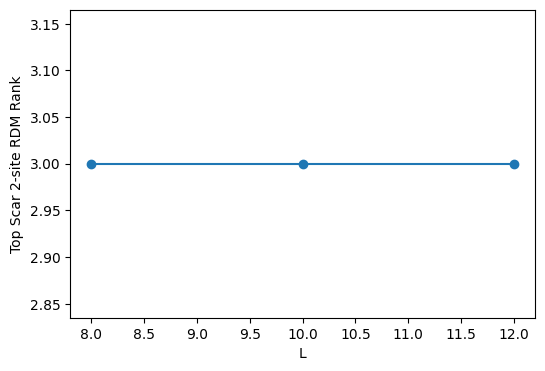

In [19]:
# 2 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_2_tar_e, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 2-site RDM Rank')
plt.savefig('hb_scar_2e.png', dpi=300, bbox_inches='tight')
plt.show()

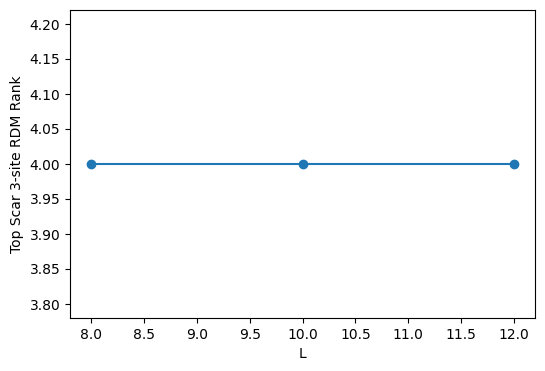

In [20]:
# 3 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_3_tar_e, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 3-site RDM Rank')
plt.savefig('hb_scar_3e.png', dpi=300, bbox_inches='tight')
plt.show()

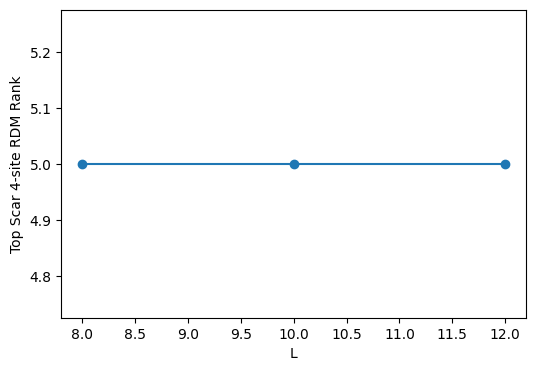

In [21]:
# 4 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_4_tar_e, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 4-site RDM Rank')
plt.savefig('hb_scar_4e.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
scar_state_s = [s_tower(Lt//2 -1, Lt) for Lt in tqdm(Ltar)]

# Convert each state vector to density matrix before computing entanglement entropy
scar_density_matrices_s = []
for i, state in enumerate(scar_state_s):
    scar_sparse = csr_matrix(state.reshape(-1, 1))  # Convert to sparse column vector
    scar_density_matrices_s.append(scar_sparse)

# Compute RDMs and their ranks for each system size
hb_scar_2_tar_s = []
hb_scar_3_tar_s = []
hb_scar_4_tar_s = []

for i, Lt in tqdm(enumerate(Ltar)):
    psi = scar_density_matrices_s[i]
    if not isspmatrix(psi) or psi.shape[1] != 1:
        psi = csr_matrix(psi.reshape(-1, 1))
    rdm_2 = schmidt_sparse(psi, [4]*Lt, innermost_2)
    rdm_3 = schmidt_sparse(psi, [4]*Lt, innermost_3)
    rdm_4 = schmidt_sparse(psi, [4]*Lt, innermost_4)
    
    # Compute ranks and append to lists
    hb_scar_2_tar_s.append(len(rdm_2[0]))
    hb_scar_3_tar_s.append(len(rdm_3[0]))
    hb_scar_4_tar_s.append(len(rdm_4[0]))

100%|██████████| 3/3 [00:57<00:00, 19.08s/it]
3it [00:16,  5.44s/it]


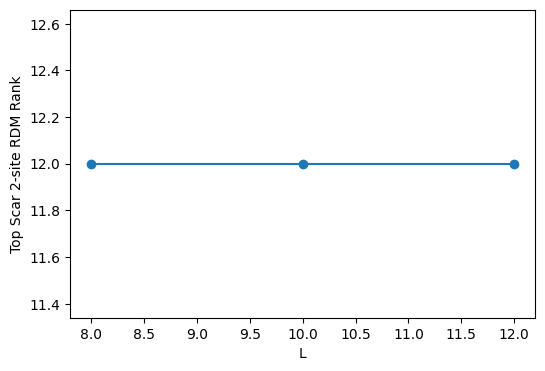

In [23]:
# 2 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_2_tar_s, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 2-site RDM Rank')
plt.savefig('hb_scar_2s.png', dpi=300, bbox_inches='tight')
plt.show()

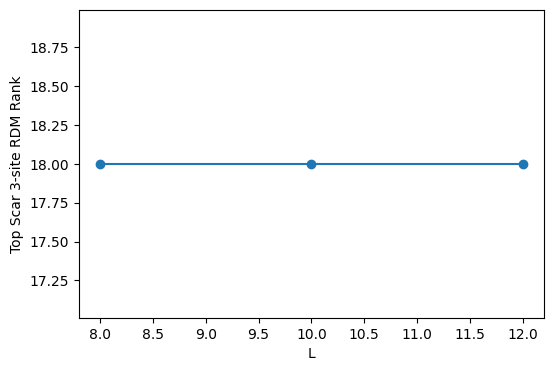

In [24]:
# 3 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_3_tar_s, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 3-site RDM Rank')
plt.savefig('hb_scar_3s.png', dpi=300, bbox_inches='tight')
plt.show()

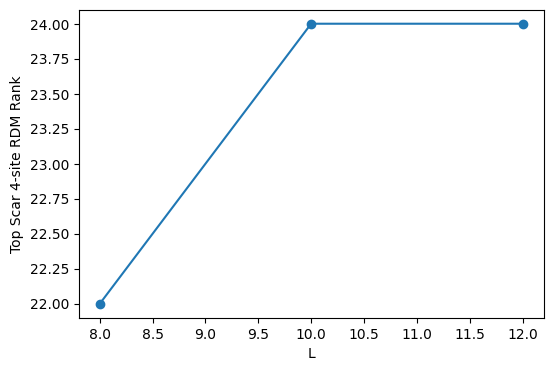

In [25]:
# 4 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_4_tar_s, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 4-site RDM Rank')
#plt.title('Domain Wall S=1/2 4-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('hb_scar_4s.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
m = 2
scar_state_t = [t_tower(m, nt, Lt) for nt, Lt in tqdm(zip(ntar, Ltar))]

# Convert each state vector to density matrix before computing entanglement entropy
scar_density_matrices_t = []
for i, state in enumerate(scar_state_t):
    scar_sparse = csr_matrix(state.reshape(-1, 1))  # Convert to sparse column vector
    scar_density_matrices_t.append(scar_sparse)

# Compute RDMs and their ranks for each system size
hb_scar_2_tar_t = []
hb_scar_3_tar_t = []
hb_scar_4_tar_t = []

for i, Lt in tqdm(enumerate(Ltar)):
    psi = scar_density_matrices_t[i]
    if not isspmatrix(psi) or psi.shape[1] != 1:
        psi = csr_matrix(psi.reshape(-1, 1))
    rdm_2 = schmidt_sparse(psi, [4]*Lt, innermost_2)
    rdm_3 = schmidt_sparse(psi, [4]*Lt, innermost_3)
    rdm_4 = schmidt_sparse(psi, [4]*Lt, innermost_4)
    
    # Compute ranks and append to lists
    hb_scar_2_tar_t.append(len(rdm_2[0]))
    hb_scar_3_tar_t.append(len(rdm_3[0]))
    hb_scar_4_tar_t.append(len(rdm_4[0]))

3it [00:39, 13.23s/it]
3it [00:13,  4.66s/it]


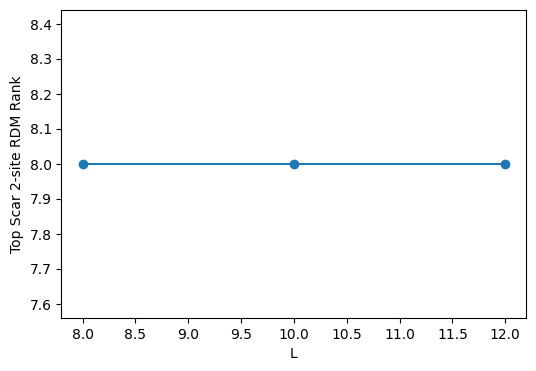

In [27]:
# 2 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_2_tar_t, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 2-site RDM Rank')
#plt.title('Domain Wall S=1/2 2-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('hb_scar_2t.png', dpi=300, bbox_inches='tight')
plt.show()

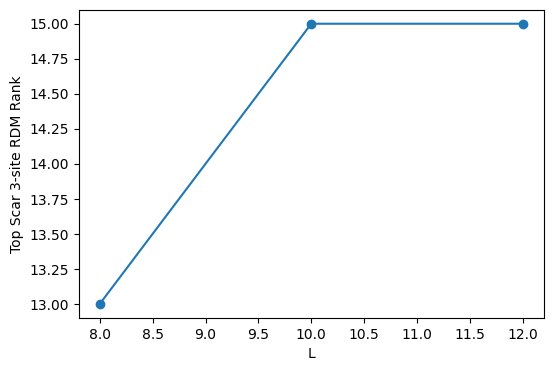

In [28]:
# 3 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_3_tar_t, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 3-site RDM Rank')
plt.savefig('hb_scar_3t.png', dpi=300, bbox_inches='tight')
plt.show()

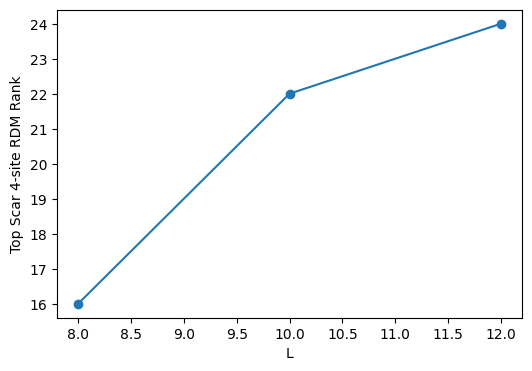

In [29]:
# 4 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_4_tar_t, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 4-site RDM Rank')
plt.savefig('hb_scar_4t.png', dpi=300, bbox_inches='tight')
plt.show()